In [125]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
from torch_geometric.loader import DataLoader
from InterleavedGCNN import InterleavedGCNN
from GraphDataset import GraphDataset

#### Parent ILP

In [124]:
# Load dataset
train_dir = f'./../dataset/training/parent_graphs'
train_data = GraphDataset(root=train_dir, data_list=[])
train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
data = train_loader.dataset[250]
data

HeteroData(
  name={ ILP='SC_10.mps' },
  var_nodes={
    x=[989, 3],
    x_sub_opt=[989],
    mask=[989],
    prob_divisor=[1],
    prob_dividend=[1],
    prob=[1],
  },
  constr_nodes={ x=[1378, 7] },
  (var_nodes, in, constr_nodes)={
    edge_index=[2, 13837],
    edge_attr=[13837, 1],
  },
  (constr_nodes, rev_in, var_nodes)={
    edge_index=[2, 13837],
    edge_attr=[13837, 1],
  }
)

#### Children ILP

In [122]:
# Load dataset
train_dir = f'./../dataset/training/children_graphs'
train_data = GraphDataset(root=train_dir, data_list=[])
train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
data = train_loader.dataset[0]
data

HeteroData(
  name='SC_10_children_ILP_0.15',
  var_nodes={
    x=[989, 3],
    y=[989],
    mask=[989],
  },
  constr_nodes={ x=[1378, 7] },
  (var_nodes, in, constr_nodes)={
    edge_index=[2, 13837],
    edge_attr=[13837, 1],
  },
  (constr_nodes, rev_in, var_nodes)={
    edge_index=[2, 13837],
    edge_attr=[13837, 1],
  }
)

In [116]:
all_x = data["var_nodes"].x[:, 1]
unassigned_x = all_x <= 0.5

mask = data["var_nodes"].mask

torch.all(unassigned_x == mask), unassigned_x.sum(), mask.sum()

(tensor(True), tensor(1518), tensor(1518))

In [117]:
assigned_x = all_x[all_x > 0.5]
assigned_y = data["var_nodes"].y[~mask]
assigned_x.sum(), assigned_y.sum()

(tensor(383.3023), tensor(427.))

(0.6, 1.4)

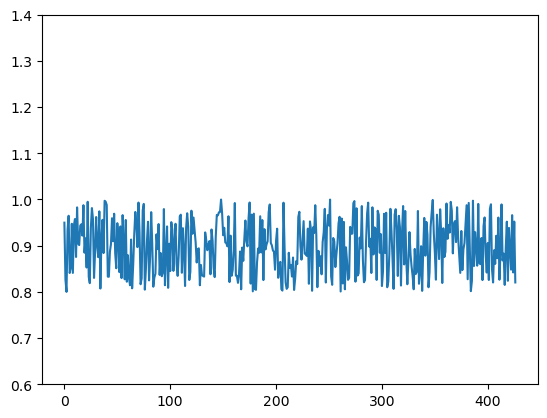

In [118]:
plt.plot(assigned_x)
plt.ylim(0.6, 1.4)